# FINAL REPORT

Course: Applied Parallel Programming

18127039 -  Lâm Ngọc Phương Anh

18127046 - Lư Ngọc Liên 

1653098 - Võ Minh Tú


# Enhancing Document Image

## I.Phát biểu bài toán




### 1.Tổng quan


Enhacing document image là một bước trong công việc xử lý ảnh, là bước nền cơ bản hỗ trợ cho các chức năng nâng cao khác như scan hình ảnh, chuyển đổi ảnh thành text, điều chỉnh lại góc chụp của bức ảnh.

Một vài ứng dụng sử dụng bài toán này là:
- Chức năng scan ảnh trong ứng dụng Note của Iphone
- CamScanner

### 2.Mô tả đầu ra và đầu vào của bài toán






* Đầu vào: một bức ảnh có góc chụp không trực diện với màn hình
* Đầu ra: Bức ảnh có góc chụp trực diện với màn hình (bỏ đi các background dư thừa)

![](https://i.imgur.com/8cfHARR.png)

*cre*: [dropbox.Tech, Jongmin Baek, Aug 16, 2016, Fast document rectification and enhancement](https://dropbox.tech/machine-learning/fast-document-rectification-and-enhancement)

### **3.Các bước thực hiện**
* Phát hiện biên cạnh
* Lấy viền của đối tượng dựa trên các cạnh đã xác định
* Đưa ảnh tài liệu về đối diện màn hình
* Điều chỉnh độ tương phản, độ sáng của bức ảnh

#### Bước 1: Phát hiện biên cạnh

https://minhng.info/tutorials/xu-ly-anh-opencv-hien-thuc-canny-edge.html

* Phát hiện biên cạnh là bước tìm ra các biên thuộc các đối tượng trong ảnh, nhầm phân tách và biết được hình dạng (shape) các đối tượng đó.
* Có 2 thuật toán nổi tiếng cho bài toán này là Sobel edge detector và Canny edge detector.
* Trong bài toán này nhóm xin chọn sử dụng thuật toán Canny edge detector. Thuật toán gồm 4 bước
    1. Giảm nhiễu: tiến hành làm mờ và giảm nhiễu cho bức ảnh bằng Gaussian ([Công thức của Gaussian Filter](https://docs.opencv.org/2.4/doc/tutorials/imgproc/gausian_median_blur_bilateral_filter/gausian_median_blur_bilateral_filter.html#gaussian-filter))
    2. Tình Gradient và hướng gradient: Sử dụng bộ lọc Sobel X và Sobel Y để lấy ra được đạo hàm theo chiều ngang (Gx) và dọc của bức ảnh (Gy). Từ đó ta sẽ tính được  gradient (độ lớn của sự biến đổi mức sáng ở vị trí pixel tương ứng với ảnh gốc) và hướng của từng pixel trong ảnh theo công thức sau. Trong đó hướng của cạnh được chia thành 4 hướng đại diện: ngang (0 độ), chéo bên phải (45 độ), dọc (90 độ), chéo bên trái (135 độ). 
  $$Edge\_Gradient(G) = \sqrt{G^2_x + G^2_y}$$

  $$Angle (Θ) = tan^{-1} (\frac{G_y}{G_x})$$
  3. Tính non-max suppression: Mục đích lọc bỏ các pixel không phải là cực đại cục bộ. Ta sử dụng 1 filter 3x3 chạy lần lượt qua các pixel của ảnh sau khi đã gradient. Trong các lần chạy, ta xét độ lớn của pixel hiện tại có phải là cực đại so với 2 hàng xóm (dựa trên hướng gradient)  hay không. Nếu là cực đại thì ghi nhận lại pixel đó, ngược lại set độ lớn của pixel đó bằng 0.
  4. Lọc ngưỡng: ở đây ta có 2 giá trị được gọi là maxVal và minVal. Nếu pixel hiện tại có giá trị lớn hơn maxVal thì pixel đó là cạnh, nhỏ hơn minVal thì bị loại bỏ. Còn các pixel nằm giữa maxVal và minVal, ta sẽ xét nó nằm gần với bên nào để quyết định có giữ lại nó hay không. 



* **Có nên tăng tốc giai đoạn xử lý ảnh này không? Tại sao? Và nếu cần tăng tốc thì có thể áp dụng lập trình song song vào không?**
    * **Nên** Thời gian để nhân tích chấp có thể khá lâu nếu bức ảnh có kích thước lớn. 
    * Có thể áp dụng lập trình song song vào ở các bước 1 và bước tính gradient của bước 2 vì các pixel sẽ được tính toán một cách độc lập.

#### Bước 2: Lấy viền của đối tượng dựa trên các cạnh đã xác định

* Mục tiêu của bước này này là lấy ra được viền của ảnh đã lấy biên, các pixel của ảnh lúc này chỉ là 0 hoặc 255. Sử dụng hàm OpenCV cho bước này vì nhóm không tìm được thuật toán tham khảo để có thể thực hiện cài đặt tuần tự và đưa ra đánh giá. Giá trị trả ra của hàm là toàn bộ các viền có trong ảnh, các viền ở đây là tập hợp các pixel có giá trị 255 và liền kề nhau.

#### Bước 3: Đưa ảnh tài liệu về đối diện màn hình


* Lúc này, ta sẽ lấy các pixel nằm bên trong viền đã được nhận diện ở bước trước đó, thực hiện việc map các điểm ảnh này sang một không gian tọa độ mới (đối diện màn hình).

* Các hướng tiếp cận cho bước có điểm chung là đều được thực hiện bằng cách nhân ma trận trên một hệ tọa độ đồng nhất ([Homogeneous coordinates](https://en.wikipedia.org/wiki/Homogeneous_coordinates)):

    * Sử dụng các **phép xoay ảnh**: Xoay bức ảnh quanh một điểm theo một góc xác định nào đó, vẫn giữ nguyên các tính chất của ảnh (các góc của ảnh vẫn giữ nguyên).
    * Sử dụng phép biến đổi affine: Cần xác định ba điểm trên ảnh gốc và vị trí của chúng trên ảnh kết quả. Biến đổi affine giúp tạo ra nhiều tư thế, biến thể khác nhau của vật thể. Các biến thể này sẽ được bảo toàn tính song song, tỉ lệ khoảng cách của vật thể và các đường thẳng trong ảnh.
    * Sử dụng biến đổi phối cảnh (Perspective transform hoặc Homography transform): Đây là một phép biến đổi đặc biệt khi mà ảnh kết quả không được đảm bảo về góc, độ dài, tính song song so với ảnh gốc ngoại trừ bảo toàn đường thẳng.


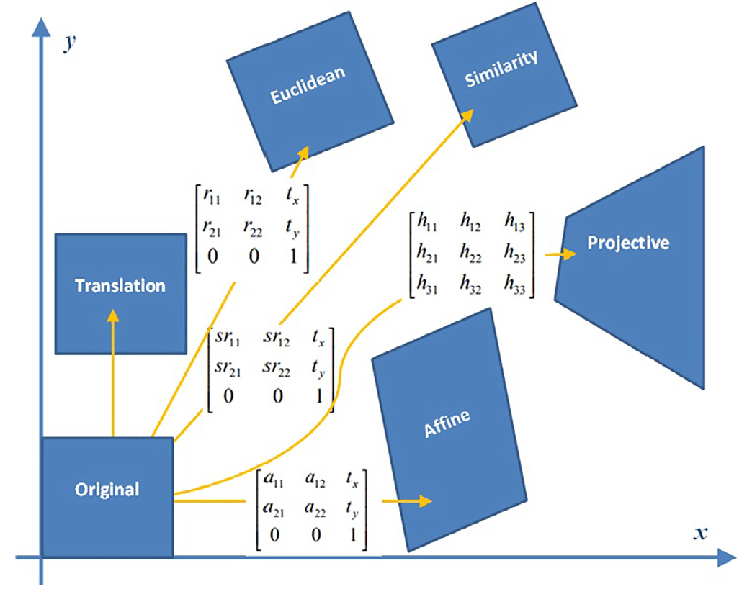

cre: A. Soycan - Metin Soycan (2018), Perspective correction of building facade images for architectural applications. Engineering Science and Technology an International Journal 22(3).

##### **Phép biến đổi Homography**

* Đối với bài toán này, hình dạng của văn bản trong ảnh đầu vào đa dạng và không phải luôn là chữ nhật $→$ **biến đổi phối cảnh** sẽ là giải pháp tốt nhất để có thể đưa văn bản về đối diện màn hình.

* Các bước thực hiện phép biến đổi Homography:
    1. Xác định 4 điểm góc của văn bản trong ảnh đầu vào (source points) và xem nó là 4 đỉnh của ảnh đầu ra (target points).
    2. Dựa trên 4 điểm đã chọn, tính chiều dài và rộng cho ảnh đầu ra $→$ xác định được tọa độ 4 đỉnh trong không gian mới và kích thước của ảnh output.
    3. Khi đã có được source và target points thì ta có thể dễ dàng tính được ma trận biến đổi **H** (3x3).
    4. Thực hiện việc chuyển đổi tọa độ cho từng điểm ảnh bằng công thức sau:
    $$dst(x,y) = src(\frac{H_{0,0}x + H_{0,1}y + H_{0,2}}{H_{2,0}x + H_{2,1}y + H_{2,2}},\frac{H_{1,0}x + H_{1,1}y + H_{1,2}}{H_{2,0}x + H_{2,1}y + H_{2,2}})$$ 


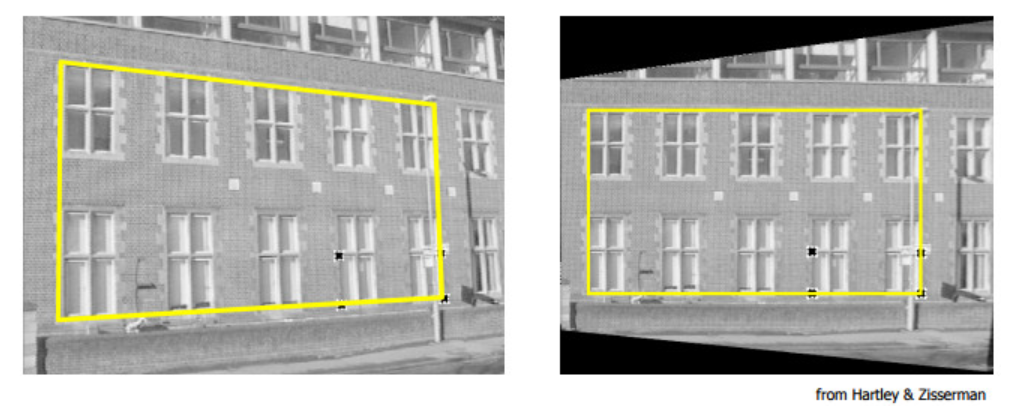

cre: [OpenCV, Basic concepts of the homography explained with code.](https://docs.opencv.org/4.x/d9/dab/tutorial_homography.html)

* **Có nên tăng tốc giai đoạn xử lý ảnh này không? Tại sao? Và nếu cần tăng tốc thì có thể áp dụng lập trình song song vào không?**
    * **Nên** vì có thể thấy tại bước 4 của quá trình này là việc xác định tọa độ mới của từng pixel, điều này có thể sẽ tốn nhiều thời gian khi kích thước bức ảnh lớn.
    * Có thể áp dụng lập trình song song vào **bước 4** vì các pixel sẽ được tính toán một cách độc lập.

#### Bước 4: Điều chỉnh độ tương phản, độ sáng của bức ảnh

* Điều chỉnh độ sáng, độ tương phản của bức ảnh sau khi đã đưa ảnh tài liệu về chính diện màn hình.
* Lúc này ta sẽ sử dụng công thức với 2 quy trình điểm thường được sử dụng là nhân và cộng với một hằng số: 


> g (x) = αf (x) + β


   

* Các tham số α> 0 và β thường được gọi là 
gain and bias parameters, đôi khi các thông số này được cho là để kiểm soát độ tương phản và độ sáng tương ứng.

* Ta có thể coi f(x) là các pixel của ảnh đầu vào và g(x) là các pixel của ảnh đầu ra.

* Chúng ta có thể viết cho dể hình dung:
   


>   g (i, j) = α⋅f (i, j) + β




* Trong đó i và j là pixel nằm ở hàng thứ i và cột thứ j.















* **Có nên tăng tốc giai đoạn xử lý ảnh này không? Tại sao? Và nếu cần tăng tốc thì có thể áp dụng lập trình song song vào không?**
    * **Nên** vì có thể thấy tại bước này của quá trình là việc xác định và tiếp cận  từng pixel của 3 kênh màu của ảnh là RGB, điều này có thể sẽ tốn nhiều thời gian khi kích thước bức ảnh lớn.
    * Có thể áp dụng lập trình song song vào **bước 4** vì các pixel sẽ được tính toán một cách độc lập.

### 4.Khai báo thư viện + đọc ảnh đầu vào

Các phần sử dụng hàm của OpenCV :
-  [Canny edge detection](https://towardsdatascience.com/canny-edge-detection-step-by-step-in-python-computer-vision-b49c3a2d8123?fbclid=IwAR0e9rtoffrqAwTEx9bc8TzpX3y0bgx3UcDRkJR_njyENCY8heaObum6Nks)

- [Find coutours](https://stackoverflow.com/questions/62039403/python-opencv-finding-the-biggest-contour)

- [Homography](https://pyimagesearch.com/2014/09/01/build-kick-ass-mobile-document-scanner-just-5-minutes/)

In [1]:
import numpy as np
from numba import *
from PIL import *
import requests
from io import BytesIO
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import cv2
from scipy import ndimage
import math
import time
from numba import jit, cuda

from itertools import permutations
import pandas as pd

from skimage.filters import threshold_local

# from google.colab.patches import cv2_imshow
# import imutils

import warnings
warnings.filterwarnings('ignore')

In [2]:
# img_path = 'poster.png'
# img_path = '../input/app-hcmus/poster.png'
img_path = '../input/image-test/poster.png'
img = np.asarray(Image.open(img_path))

## II.Tuần tự

### 1.Các hàm xử lý ảnh được viết theo 3 cách (OpenCV, Numpy, @jit)

#### a.Hàm làm xám ảnh (@jit)

In [3]:
@jit(cache=True)
def convert_RGB_Gray_py(img):
    gray = np.zeros((img.shape[0],img.shape[1]))
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            gray[i,j] = img[i,j,0] * 0.2989  + img[i,j,1] * 0.5870 + img[i,j,2] * 0.1141
    
    return gray

#### b.Hàm tính tích chập (@jit)

In [4]:
@jit(cache=True)
def convolutionLayer_py(img, kernel):
    img_out = np.zeros(img.shape)
    rows, cols = img.shape
    rows_k, cols_k = kernel.shape
    for r in range(rows):
        for c in range(cols):
            out = 0
            for r_k in range(rows_k):
                for c_k in range(cols_k):
                    in_r = r - rows_k//2 + r_k;
                    in_c = c - cols_k//2 + c_k;
                    in_r = min(max(0, in_r), rows - 1);
                    in_c = min(max(0, in_c), cols - 1);
                    out += kernel[r_k,c_k] * img[in_r,in_c];
            img_out[r,c] = out
    return img_out

#### c.Hàm tính element-wise cho ma trận (@jit)

In [5]:
@jit(cache=True)
def matrixElementWise(mat1, mat2 = None, op='*', is_scalar = False):
    out_mat = np.zeros(mat1.shape)
    if is_scalar:
        if op == '+':
            for i in range(mat1.shape[0]):
                for j in range(mat1.shape[1]):
                    out_mat[i,j] = mat1[i,j] + mat2        
        else:
            for i in range(mat1.shape[0]):
                for j in range(mat1.shape[1]):
                    out_mat[i,j] = mat1[i,j] * mat2
    else:
        if op == '+':
            for i in range(mat1.shape[0]):
                for j in range(mat1.shape[1]):
                    out_mat[i,j] = mat1[i,j] + mat2[i,j]
        elif op == 'sqrt':
            for i in range(mat1.shape[0]):
                for j in range(mat1.shape[1]):
                    out_mat[i,j] = mat1[i,j] ** 0.5
        elif op == 'abs':
            for i in range(mat1.shape[0]):
                for j in range(mat1.shape[1]):
                    out_mat[i,j] = abs(mat1[i,j])
        elif op == 'arctan2':
            for i in range(mat1.shape[0]):
                for j in range(mat1.shape[1]):
                    out_mat[i,j] = math.atan2(mat1[i,j], mat2[i,j])
        else:
            for i in range(mat1.shape[0]):
                for j in range(mat1.shape[1]):
                    out_mat[i,j] = mat1[i,j] * mat2[i,j]
    
    return out_mat

#### d.Gaussian kernel và Sobel kernel

In [6]:
gau_kernel_size = 3
gau_kernel = cv2.getGaussianKernel(gau_kernel_size**2,1)
gau_kernel = gau_kernel.reshape((gau_kernel_size,gau_kernel_size))

In [7]:
sobel_x_kernel, sobel_y_kernel = np.array([[-1,0,1],[-2,0,2],[-1,0,1]], np.float32), np.array([[1,2,1],[0,0,0],[-1,-2,-1]], np.float32)

#### e.Hàm tính edge gradient (OpenCV, @jit)

In [8]:
def edgeGradient_cv(img):
    sobel_x = cv2.Sobel(img,cv2.CV_64F,1,0,ksize = 3)
    sobel_y = cv2.Sobel(img,cv2.CV_64F,0,1,ksize = 3)
    edge_sobel = np.hypot(sobel_x, sobel_y)
    
    #convert radian value to degree
    angle = np.arctan2(sobel_y, sobel_x) * 180 / np.pi
    angle[angle<0] += 180
        
    return edge_sobel, angle

@jit(cache=True)
def edgeGradient_py(img, sobel_x_kernel, sobel_y_kernel):
    sobel_x = convolutionLayer_py(img,sobel_x_kernel)
    sobel_y = convolutionLayer_py(img,sobel_y_kernel)
    
    edge_sobel = matrixElementWise(
        matrixElementWise(
            matrixElementWise(sobel_x,sobel_x), 
            matrixElementWise(sobel_y,sobel_y), 
            op='+'),
        op='sqrt')
    
    #convert radian value to degree
    angle = matrixElementWise(
        matrixElementWise(
            sobel_y, 
            sobel_x, 
            op='arctan2'),
        (180 / np.pi),
        is_scalar=True)
    
    for r in range(img.shape[0]):
        for c in range(img.shape[1]):
            if angle[r,c] < 0:
                angle[r,c] += 180
                    
    return edge_sobel, angle

#### f.Hàm xác định non max suppression (@jit)

In [9]:
@jit(cache=True)
def nonMaxSuppression(img, angle):
    Z = np.zeros(img.shape, np.int32)

    for r in range(1, img.shape[0]-1):
        for c in range(1, img.shape[1]-1):
            q, t = 255, 255
            
            if 0 <= angle[r,c] < 22.5 or 180 >= angle[r,c] >= 157.5:
                q, t = img[r, c+1], img[r, c-1]
            elif 67.5 > angle[r,c] >= 22.5:
                q, t = img[r+1, c-1], img[r-1, c+1]
            elif 112.5 > angle[r,c] >= 67.5:
                q, t = img[r+1, c], img[r-1, c]
            elif 157.5 > angle[r,c] >= 112.5:
                q, t = img[r-1, c-1], img[r+1, c+1]
            
            if img[r,c] >=q and img[r,c] >=t:
                Z[r,c] = img[r,c]
            else:
                Z[r,c] = 0
    return Z

#### g.Hàm lọc ngưỡng (@jit)

In [10]:
@jit(cache=True)
def hysteresisThreshold(img, min_thres, max_thres):

    canny_mask = np.zeros(img.shape, np.int32)
    max_val = img.max() * max_thres
    min_val = max_val * min_thres
    
    for y in range(img.shape[0]):
        for x in range(img.shape[1]):
            if img[y,x] > max_val:
                canny_mask[y,x] = 255
            elif img[y,x] > min_val:
                is_edge = False
                for i in range(max(0, y-1), min(img.shape[0], y+2)):
                    for j in range(max(0, x-1), min(img.shape[1], x+2)):
                        if img[i,j] > max_val:
                            is_edge = True
                            canny_mask[y,x] = 255
                            break
                    if is_edge:
                        break
    return canny_mask

#### h.Hàm xác định 4 góc (Numpy, @jit)
* Chọn ra các điểm phù hợp làm góc dựa trên các mảng chứa các điểm tọa độ cực

In [11]:
@jit(cache=True)
def get_pos (lst_can, min, max, pos = 0):
    if len(lst_can[(lst_can[:,pos] == min) | (lst_can[:,pos] == max)]) == 0:
        ans1 = lst_can[lst_can[:,pos] == lst_can[:,pos].max()]
        return ans1[0], -1
    else:
        if  len(lst_can[(lst_can[:,pos] == min) | (lst_can[:,pos] == max)]) == 2:
            ans1 = lst_can[(lst_can[:,pos] == min)]
            ans2 = lst_can[(lst_can[:,pos] == max)]
            return ans1[0], ans2[0]
        else:
            if  len(lst_can[(lst_can[:,pos] == max)]) == 1:
                ans2 = lst_can[(lst_can[:,pos] == max)]
                return ans2[0], -1
            else:
                ans2 = lst_can[(lst_can[:,pos] == min)]
                return ans2[0], -1

* **get_points**: từ kết quả của hàm get_pos, ta có thể có các giá trị -1 -> hàm này sẽ lọc ra và chỉ giữ những giá trị là các tọa độ.
* **get_4_vertices**: lọc mảng các tọa độ, lấy ra các giá trị độc nhất -> đây sẽ là 4 góc của ảnh.

In [12]:
def get_points(xy, lst):
    if xy[1] == -1:
        lst.append(xy[0])
    else:
        lst.extend(xy)

def get_4_vertices(t, l, r, b, lst_v):
    lst = []

    get_points(list(t), lst)
    get_points(list(l), lst)
    get_points(list(r), lst)
    get_points(list(b), lst)

    for i in range(len(lst)):
        flag = False
        for j in range(len(lst_v)):
            comp = lst[i] == lst_v[j]
            if comp.any():
                flag = True
        if not flag:
            lst_v.append(lst[i])

* **get_t_b**: sắp xếp các tọa độ lại theo vị trí top hoặc bottom
* **order_points_py**, **order_points_np**: sắp xếp lại thứ tự của các góc theo thứ tự: top-left, bottom-left, bottom-right, top-right

In [13]:
def order_points_np(pts):
    rect = np.zeros((4, 2), dtype = "float32")

    s = pts.sum(axis = 1)
    rect[0] = pts[np.argmin(s)]
    rect[2] = pts[np.argmax(s)]

    diff = np.diff(pts, axis = 1)
    rect[1] = pts[np.argmin(diff)]
    rect[3] = pts[np.argmax(diff)]

    return rect

def order_points_py(pts, max_x, max_y, min_x, min_y):
    lst = [i for i in range(len(pts))]
    pts_permutations = set(permutations(lst))
    for i in pts_permutations:
        t1, t2, s1, s2 = pts[i[0]], pts[i[1]], pts[i[2]], pts[i[3]]
        A = np.array([[t1[0], 1], 
                    [t2[0], 1]])
        y = np.array([t1[1], t2[1]])

        x1 = np.linalg.solve(A, y)

        A = np.array([[s1[0], 1], 
                    [s2[0], 1]])
        y = np.array([s1[1], s2[1]])

        x2 = np.linalg.solve(A, y)

        x  = (x2[1] - x1[1]) / (x1[0] - x2[0])
        x = x if min_x < x < max_x else -1

        y = x1[0] * x + x1[1]
        y = y if min_y < y < max_y else -1

        if x != -1 and y != -1:
            return np.array([t1, s1, t2, s2]) #tl, tr, br, bl


#### i.Hàm xác định các tọa độ mới cho ảnh (OpenCV, @jit)

In [14]:
def four_point_transform(image, pts):
    rect = order_points_np(pts)
    (tl, tr, br, bl) = rect

    widthA = np.sqrt(((br[0] - bl[0]) ** 2) + ((br[1] - bl[1]) ** 2))
    widthB = np.sqrt(((tr[0] - tl[0]) ** 2) + ((tr[1] - tl[1]) ** 2))
    maxWidth = max(int(widthA), int(widthB))

    heightA = np.sqrt(((tr[0] - br[0]) ** 2) + ((tr[1] - br[1]) ** 2))
    heightB = np.sqrt(((tl[0] - bl[0]) ** 2) + ((tl[1] - bl[1]) ** 2))
    maxHeight = max(int(heightA), int(heightB))
    dst = np.array([
        [0, 0],
        [maxWidth - 1, 0],
        [maxWidth - 1, maxHeight - 1],
        [0, maxHeight - 1]], dtype = "float32")

    M = cv2.getPerspectiveTransform(rect, dst)
    warped = cv2.warpPerspective(image, M, (maxWidth, maxHeight))

    return warped

@jit(cache = True)
def map_pos_homo(img, new_i, H):
	new_img = new_i.copy()
	for r in range(new_img.shape[0]):
		for c in range(new_img.shape[1]):
			x = int((H[0,0] * c + H[0,1] * r + H[0,2]) / (H[2,0] * c + H[2,1] * r + H[2,2]))
			y = int((H[1,0] * c + H[1,1] * r + H[1,2]) / (H[2,0] * c + H[2,1] * r + H[2,2]))
			if 0 <= y < img.shape[0] and 0 <= x < img.shape[1]:
				new_img[r, c] = img[y, x]
	return new_img

#### j.Hàm điều chỉnh độ sáng, độ tương phản (OpenCV, @jit)

In [15]:
@jit(cache = True)
def adjustBandC(image, new_image, alpha, beta):
    for y in range(image.shape[0]):
        for x in range(image.shape[1]):
            for c in range(image.shape[2]):
                new_image[y,x,c] = int(min(max(alpha*image[y,x,c] + beta, 0), 255))

In [16]:
def controller(img, brightness=255, contrast=127):
	brightness = int((brightness - 0) * (255 - (-255)) / (510 - 0) + (-255))
	contrast = int((contrast - 0) * (127 - (-127)) / (254 - 0) + (-127))
	if brightness != 0:
		if brightness > 0:
			shadow = brightness
			max = 255
		else:
			shadow = 0
			max = 255 + brightness

		al_pha = (max - shadow) / 255
		ga_mma = shadow

		# The function addWeighted calculates
		# the weighted sum of two arrays
		cal = cv2.addWeighted(img, al_pha,img, 0, ga_mma)
	else:
		cal = img

	if contrast != 0:
		Alpha = float(131 * (contrast + 127)) / (127 * (131 - contrast))
		Gamma = 127 * (1 - Alpha)

		# The function addWeighted calculates
		# the weighted sum of two arrays
		cal = cv2.addWeighted(cal, Alpha,cal, 0, Gamma)
	return cal

### 2.Thực thi bằng OpenCV

#### a.Làm xám ảnh

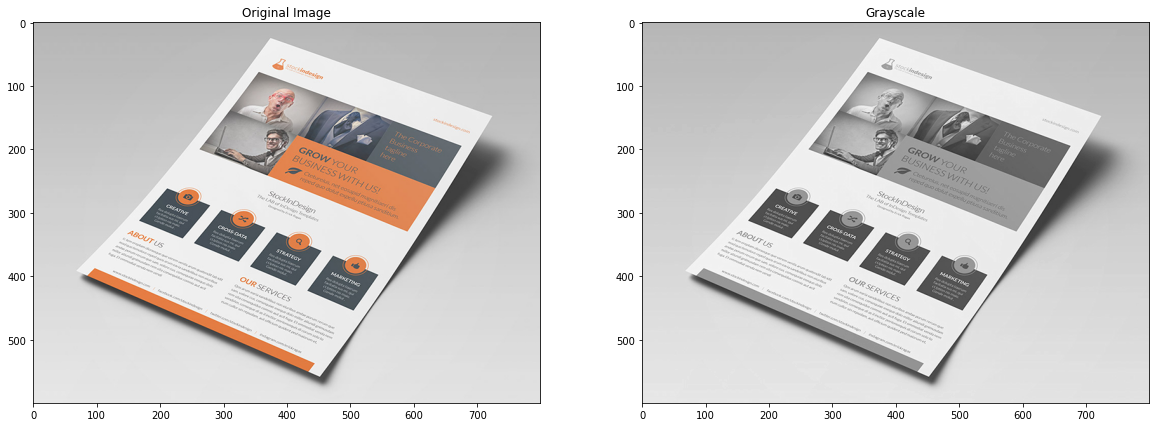

In [17]:
s = time.time()
gray_cv = cv2.cvtColor(cv2.cvtColor(img,cv2.COLOR_RGB2BGR), cv2.COLOR_BGR2GRAY)
time_gray_cv = time.time() - s

fig, axis = plt.subplots(1,2, figsize = (20,10));
axis[0].imshow(img);
axis[0].set_title('Original Image');
axis[1].imshow(gray_cv,cmap = 'gray');
axis[1].set_title('Grayscale');

#### b.Phát hiện biên cạnh

In [18]:
s = time.time() 
gaussianBlur_cv = cv2.GaussianBlur(gray_cv,(gau_kernel_size, gau_kernel_size),1)
canny_edge_cv = cv2.Canny(gaussianBlur_cv, 100, 200)
time_detectEdge_cv = time.time() - s

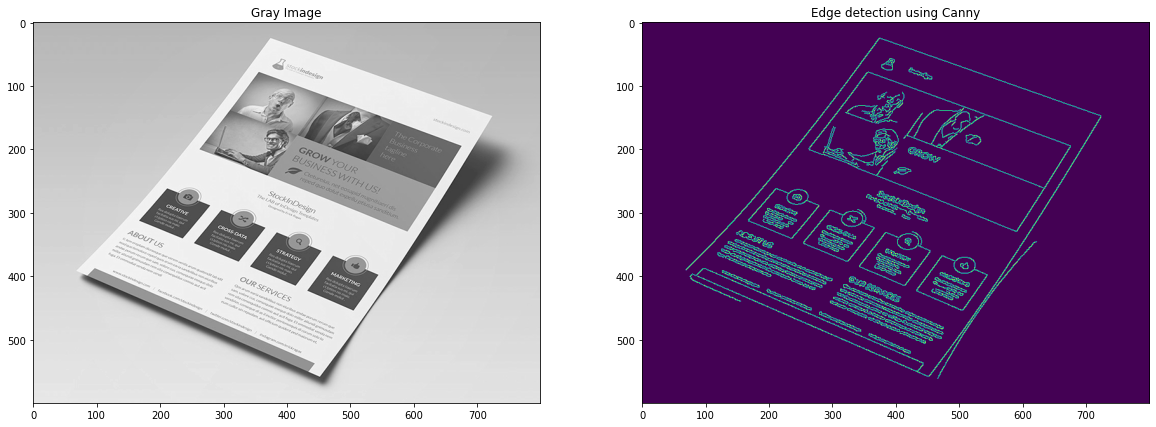

In [19]:
fig, axis = plt.subplots(1,2, figsize = (20,10));
axis[0].imshow(gray_cv, cmap = 'gray');
axis[0].set_title('Gray Image');
axis[1].imshow(canny_edge_cv);
axis[1].set_title('Edge detection using Canny');

#### c.Tìm viền ảnh

In [20]:
s = time.time() 
cnts, _ = cv2.findContours(canny_edge_cv.copy(), cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
time_findCnts_cv = time.time() - s

cnts = sorted(cnts, key = lambda x:cv2.arcLength(x,True), reverse = True)

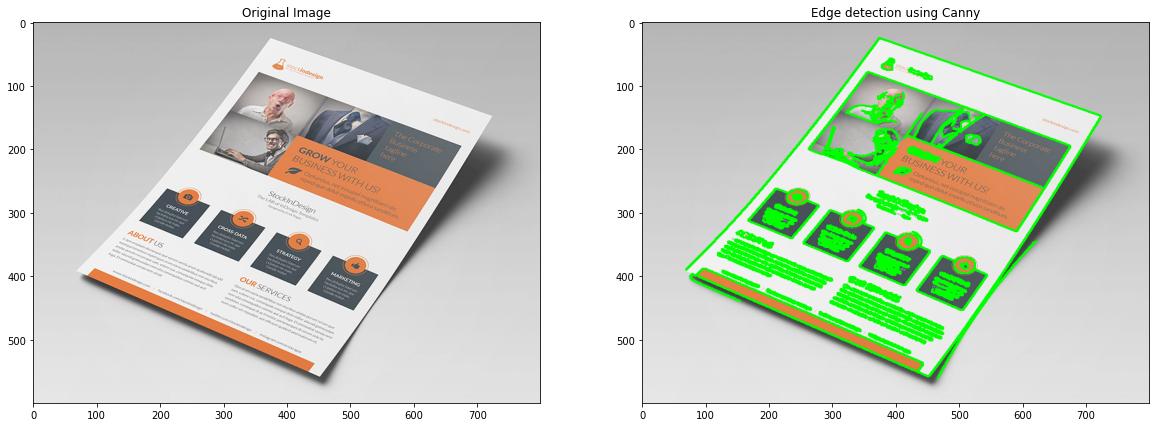

In [21]:
output_edge = img.copy()
cv2.drawContours(output_edge, cnts, -1, (0, 255, 0), 2)

fig, axis = plt.subplots(1,2, figsize = (20,10));
axis[0].imshow(img);
axis[0].set_title('Original Image');
axis[1].imshow(output_edge);
axis[1].set_title('Edge detection using Canny');

#### d.Xác định 4 đỉnh của ảnh

In [22]:
s = time.time()
choosen_cnt = cnts[0].squeeze()

max_x, max_y = choosen_cnt[:,0].max(),choosen_cnt[:,1].max()
min_x, min_y = choosen_cnt[:,0].min(), choosen_cnt[:,1].min()

b_can, t_can = choosen_cnt[choosen_cnt[:,0] == max_x], choosen_cnt[choosen_cnt[:,0] == min_x]
l_can, r_can = choosen_cnt[choosen_cnt[:,1] == min_y], choosen_cnt[choosen_cnt[:,1] == max_y]

t, b = get_pos(t_can, min_y, max_y, 1), get_pos(b_can, min_y, max_y, 1)
l, r = get_pos(l_can, min_x, max_x, 0), get_pos(r_can, min_x, max_x, 0)

four_vertices_cnts = []

get_4_vertices(t, l, r, b, four_vertices_cnts)
four_vertices_cnts = order_points_py(four_vertices_cnts, max_x, max_y, min_x, min_y)
time_4Vertices_cv = time.time() - s

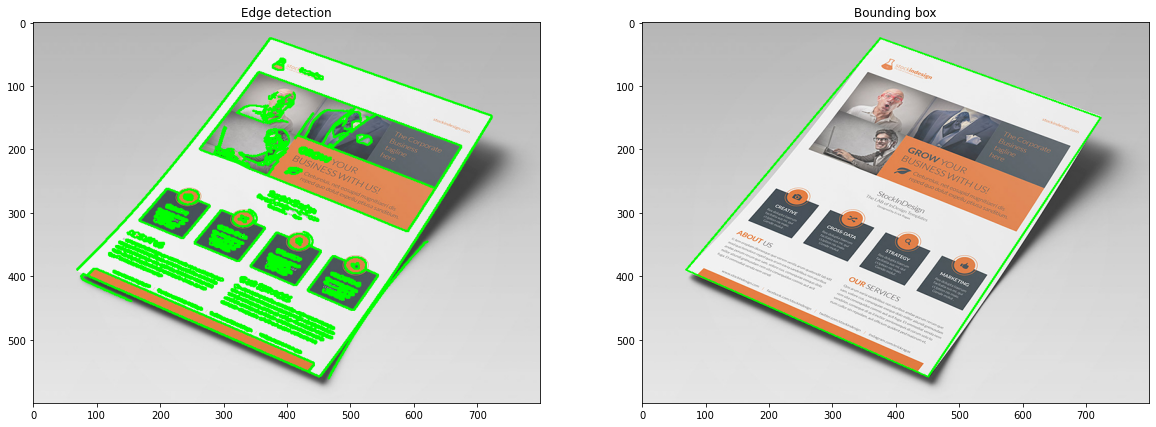

In [23]:
output_4_points = img.copy()
cv2.drawContours(output_4_points, [four_vertices_cnts], 0, (0, 255, 0), 2)

fig, axis = plt.subplots(1,2, figsize = (20,10));
axis[0].imshow(output_edge);
axis[0].set_title('Edge detection');
axis[1].imshow(output_4_points);
axis[1].set_title('Bounding box');

#### e.Tìm ma trận Homography

In [24]:
s = time.time()
tl, tr, br, bl = four_vertices_cnts

widthA = ((br[0] - bl[0]) ** 2 + (br[1] - bl[1]) ** 2) ** 0.5
widthB = ((tr[0] - tl[0]) ** 2 + (tr[1] - tl[1]) ** 2) ** 0.5

maxWidth = int(widthA) if int(widthA) > int(widthB) else int(widthB)

heightA = ((tr[0] - br[0]) ** 2 + (tr[1] - br[1]) ** 2) ** 0.5
heightB = ((tl[0] - bl[0]) ** 2 + (tl[1] - bl[1]) ** 2) ** 0.5

maxHeight = int(heightA) if int(heightA) > int(heightB) else int(heightB)

n_four_vertices_cnts = [n_tl, n_tr, n_br, n_bl] = np.array([[0,0], 
                                                   [0, maxWidth-1], 
                                                   [maxHeight-1, maxWidth - 1], 
                                                   [maxHeight - 1, 0]], dtype = 'float32')

H = np.linalg.inv(cv2.getPerspectiveTransform(four_vertices_cnts.astype('float32'), n_four_vertices_cnts))
time_homoMatrix_cv = time.time() - s

#### f.Map tọa độ mới cho ảnh

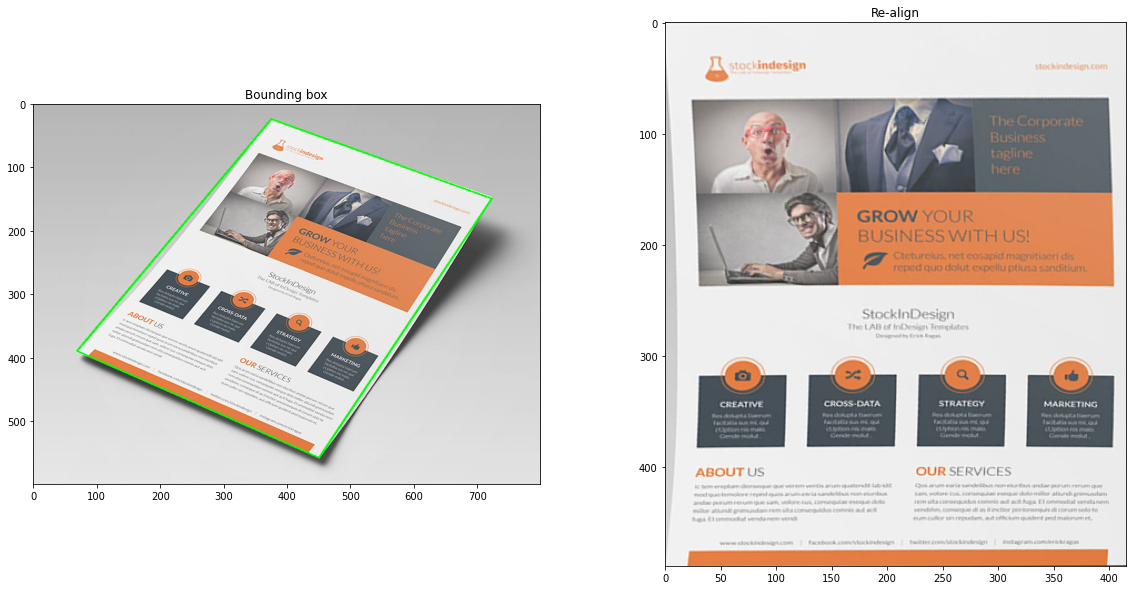

In [25]:
s = time.time()
warped = four_point_transform(img, four_vertices_cnts)
time_mapHomo_cv = time.time() - s

fig, axis = plt.subplots(1,2, figsize = (20,10));
axis[0].imshow(output_4_points);
axis[0].set_title('Bounding box');
axis[1].imshow(warped);
axis[1].set_title('Re-align');

#### g.Điều chỉnh độ sáng, độ tương phản

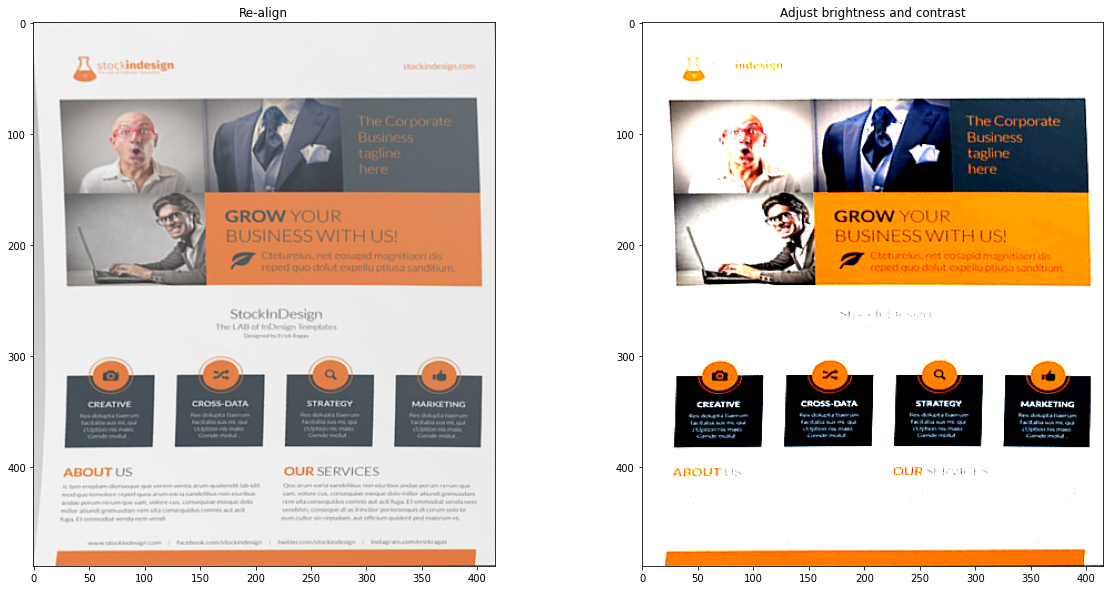

In [26]:
brightness = 255#int(input('* Enter the brightness value [0-510]: '))
contrast = 200#float(input('* Enter the contrast value [0-254]: '))

in_adjust = warped.copy()
s = time.time()
new_image_cv = controller(in_adjust, brightness, contrast)
time_step4_cv = time.time() - s

fig, axis = plt.subplots(1,2, figsize = (20,10));

axis[0].imshow(warped);
axis[0].set_title('Re-align');
axis[1].imshow(new_image_cv);
axis[1].set_title('Adjust brightness and contrast');


### 3.Thực thi bằng @jit

#### a.Làm xám ảnh

In [27]:
s = time.time()
gray_py = convert_RGB_Gray_py(img)
time_gray_py = time.time() - s

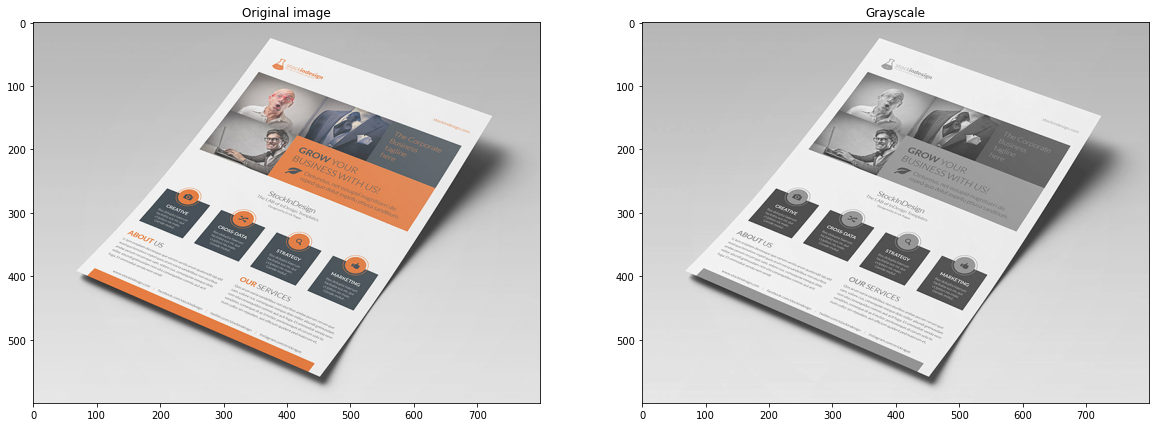

In [28]:
s = time.time()
gray_py = convert_RGB_Gray_py(img)
time_gray_cache = time.time() - s

fig, axis = plt.subplots(1,2, figsize = (20,10));
axis[0].imshow(img);
axis[0].set_title('Original image');
axis[1].imshow(gray_py, cmap='gray');
axis[1].set_title('Grayscale');


#### b.Phát hiện biên cạnh

##### **Giảm nhiễu**

In [29]:
s = time.time()
gaussianBlur_py = convolutionLayer_py(gray_py, gau_kernel)
time_blur_py = time.time() - s

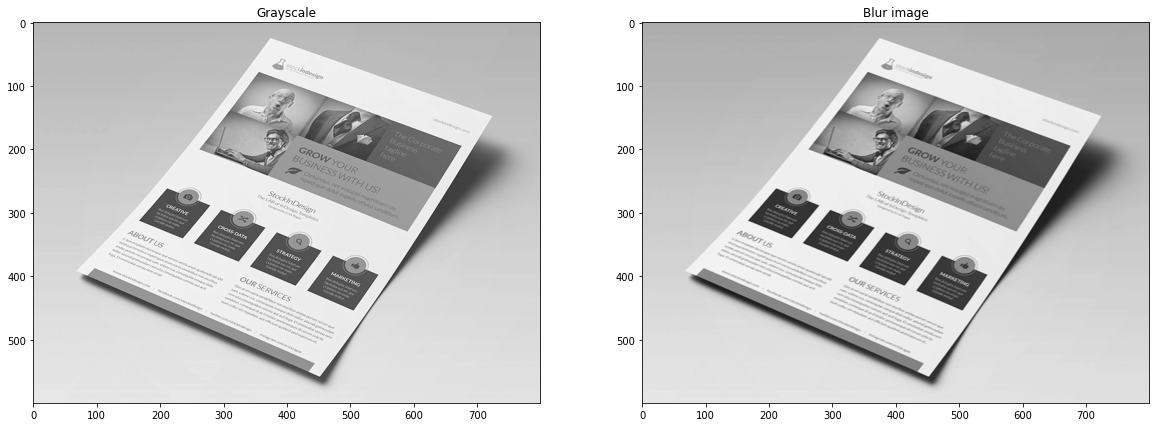

In [30]:
s = time.time()
gaussianBlur_py = convolutionLayer_py(gray_py, gau_kernel)
time_blur_cache = time.time() - s

fig, axis = plt.subplots(1,2, figsize = (20,10));
axis[0].imshow(gray_py, cmap='gray');
axis[0].set_title('Grayscale');
axis[1].imshow(gaussianBlur_py, cmap = 'gray');
axis[1].set_title('Blur image');


##### **Tính Gradient và hướng Gradient**

In [31]:
s = time.time()
edge_sobel_py, angle_py = edgeGradient_py(gaussianBlur_py, sobel_x_kernel, sobel_y_kernel)
time_grad_py = time.time() - s

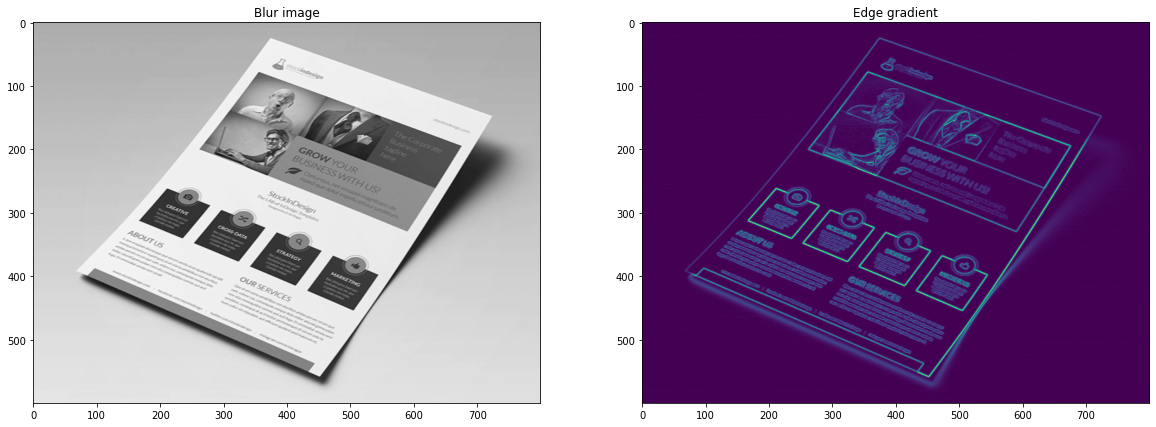

In [32]:
s = time.time()
edge_sobel_py, angle_py = edgeGradient_py(gaussianBlur_py, sobel_x_kernel, sobel_y_kernel)
time_grad_cache = time.time() - s

fig, axis = plt.subplots(1,2, figsize = (20,10));
axis[0].imshow(gaussianBlur_py, cmap ='gray');
axis[0].set_title('Blur image');
axis[1].imshow(edge_sobel_py);
axis[1].set_title('Edge gradient');

##### **Non-Maximum Suppression**

In [33]:
s = time.time()
non_max_sup_py = nonMaxSuppression(edge_sobel_py, angle_py)
time_nonmax_py = time.time() - s

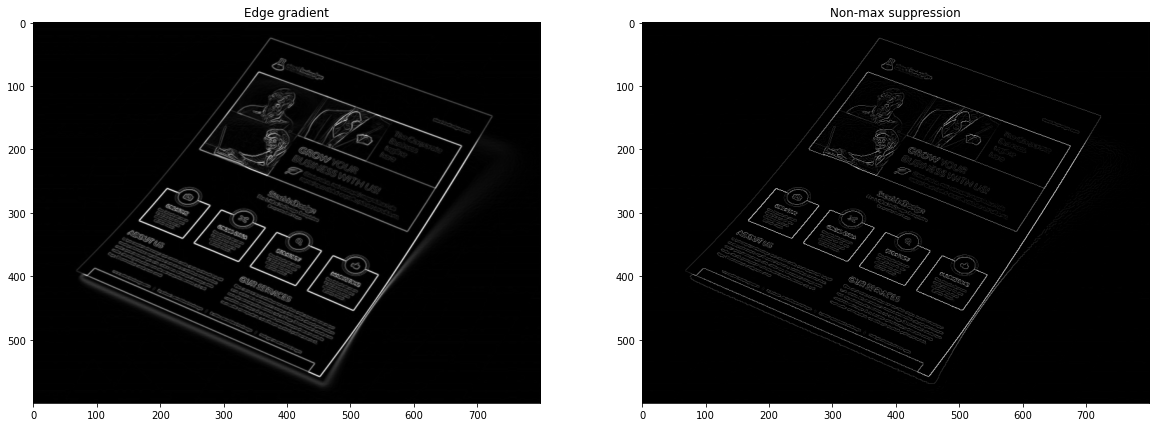

In [34]:
s = time.time()
non_max_sup_py = nonMaxSuppression(edge_sobel_py, angle_py)
time_nonmax_cache = time.time() - s

fig, axis = plt.subplots(1,2, figsize = (20,10));
axis[0].imshow(edge_sobel_py, cmap= 'gray');
axis[0].set_title('Edge gradient');
axis[1].imshow(non_max_sup_py, cmap= 'gray');
axis[1].set_title('Non-max suppression');

##### **Lọc ngưỡng**

In [35]:
s = time.time()
canny_edge_py = hysteresisThreshold(non_max_sup_py, 0.05, 0.15)
time_thres_py = time.time() - s

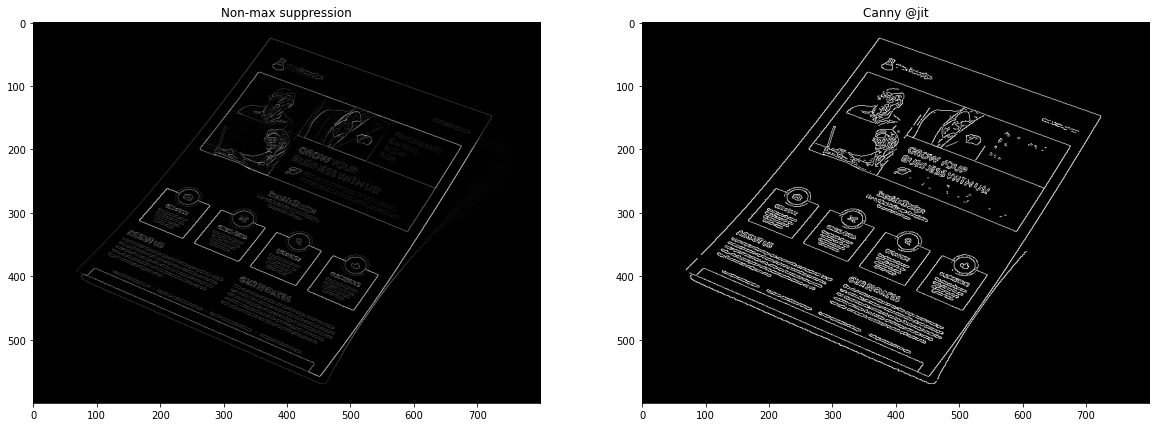

In [36]:
s = time.time()
canny_edge_py = hysteresisThreshold(non_max_sup_py, 0.05, 0.15)
time_thres_cache = time.time() - s

canny_edge_py = canny_edge_py.astype(np.uint8)

fig, axis = plt.subplots(1,2, figsize = (20,10));
axis[0].imshow(non_max_sup_py, cmap = 'gray');
axis[0].set_title('Non-max suppression');
axis[1].imshow(canny_edge_py, cmap = 'gray');
axis[1].set_title('Canny @jit');

#### c.Tìm viền ảnh

In [37]:
s = time.time() 
cnts, _ = cv2.findContours(canny_edge_py.copy(), cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
time_findCnts_py = time.time() - s

cnts = sorted(cnts, key = lambda x:cv2.arcLength(x,True), reverse = True)

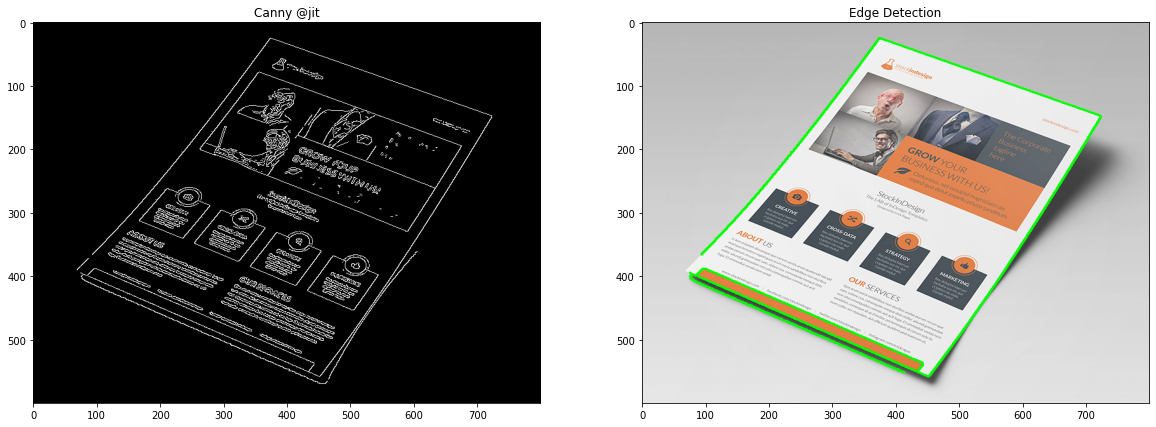

In [38]:
output_edge_jit = img.copy()
cv2.drawContours(output_edge_jit, cnts, 0, (0, 255, 0), 2)

fig, axis = plt.subplots(1,2, figsize = (20,10));
axis[0].imshow(canny_edge_py, cmap='gray');
axis[0].set_title('Canny @jit');
axis[1].imshow(output_edge_jit);
axis[1].set_title('Edge Detection');

#### d.Xác định 4 đỉnh của ảnh

In [39]:
s = time.time()
choosen_cnt = cnts[0].squeeze()

max_x, max_y = choosen_cnt[:,0].max(),choosen_cnt[:,1].max()
min_x, min_y = choosen_cnt[:,0].min(), choosen_cnt[:,1].min()

b_can, t_can = choosen_cnt[choosen_cnt[:,0] == max_x], choosen_cnt[choosen_cnt[:,0] == min_x]
l_can, r_can = choosen_cnt[choosen_cnt[:,1] == min_y], choosen_cnt[choosen_cnt[:,1] == max_y]

t, b = get_pos(t_can, min_y, max_y, 1), get_pos(b_can, min_y, max_y, 1)
l, r = get_pos(l_can, min_x, max_x, 0), get_pos(r_can, min_x, max_x, 0)

four_vertices_cnts = []

get_4_vertices(t, l, r, b, four_vertices_cnts)
four_vertices_cnts = order_points_py(four_vertices_cnts, max_x, max_y, min_x, min_y)
time_4Vertices_py = time.time() - s

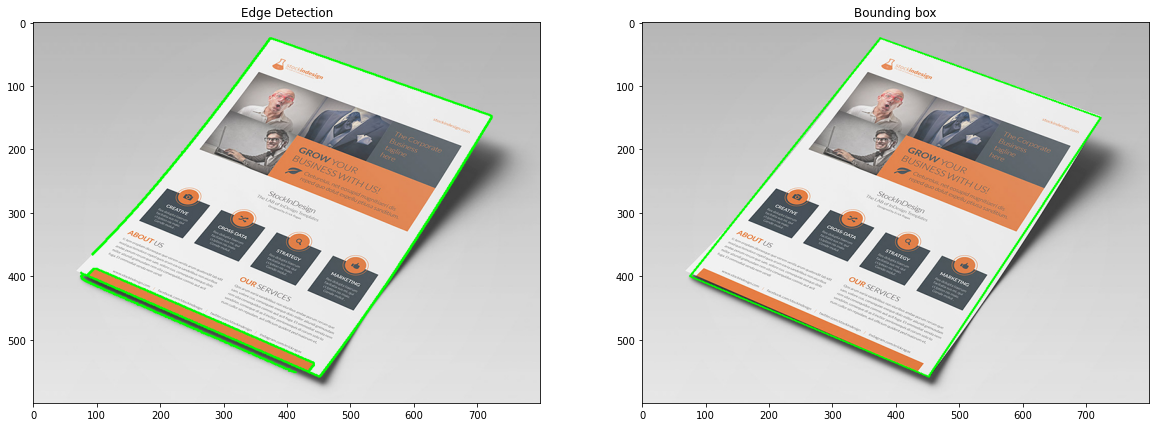

In [40]:
output_4_points_jit = img.copy()
cv2.drawContours(output_4_points_jit, [four_vertices_cnts], 0, (0, 255, 0), 2)

fig, axis = plt.subplots(1,2, figsize = (20,10));
axis[0].imshow(output_edge_jit);
axis[0].set_title('Edge Detection');
axis[1].imshow(output_4_points_jit);
axis[1].set_title('Bounding box');

#### e.Tìm ma trận Homography

In [41]:
s = time.time()
tl, tr, br, bl = four_vertices_cnts

widthA = ((br[0] - bl[0]) ** 2 + (br[1] - bl[1]) ** 2) ** 0.5
widthB = ((tr[0] - tl[0]) ** 2 + (tr[1] - tl[1]) ** 2) ** 0.5

maxWidth = int(widthA) if int(widthA) > int(widthB) else int(widthB)

heightA = ((tr[0] - br[0]) ** 2 + (tr[1] - br[1]) ** 2) ** 0.5
heightB = ((tl[0] - bl[0]) ** 2 + (tl[1] - bl[1]) ** 2) ** 0.5

maxHeight = int(heightA) if int(heightA) > int(heightB) else int(heightB)

n_four_vertices_cnts = [n_tl, n_tr, n_br, n_bl] = np.array([[0,0], 
                                                   [0, maxWidth-1], 
                                                   [maxHeight-1, maxWidth - 1], 
                                                   [maxHeight - 1, 0]], dtype = 'float32')

H = np.linalg.inv(cv2.getPerspectiveTransform(four_vertices_cnts.astype('float32'), n_four_vertices_cnts))
time_homoMatrix_py = time.time() - s

#### f.Map tọa độ mới cho ảnh

In [42]:
new_i = np.zeros((maxWidth, maxHeight, img.shape[-1]), img.dtype)

s = time.time()
new_img = map_pos_homo(img, new_i, H)
time_mapHomo_py = time.time() - s

new_img = new_img.astype(int)

In [43]:
new_i = np.zeros((maxWidth, maxHeight, img.shape[-1]), img.dtype)

s = time.time()
new_img = map_pos_homo(img, new_i, H)
time_mapHomo_cache = time.time() - s

new_img = new_img.astype(int)

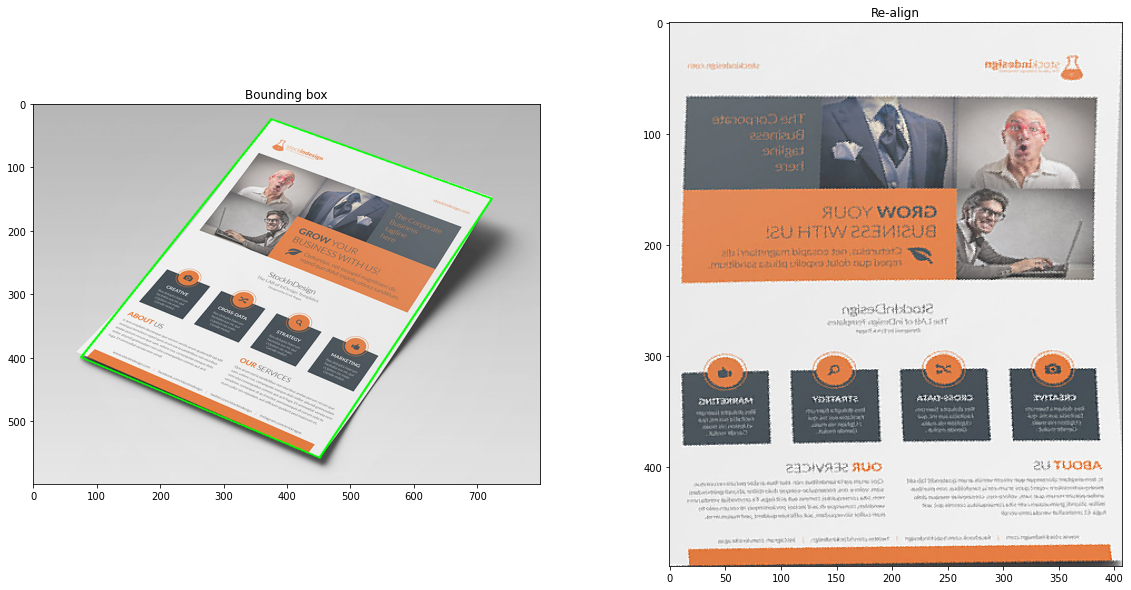

In [44]:
fig, axis = plt.subplots(1,2, figsize = (20,10));
axis[0].imshow(output_4_points_jit);
axis[0].set_title('Bounding box');
axis[1].imshow(new_img);
axis[1].set_title('Re-align');

#### g.Điều chỉnh độ sáng, độ tương phản

In [45]:
new_image_jit = np.zeros(new_img.shape, new_img.dtype)
alpha = 1.5
beta = 3
s = time.time()
adjustBandC(new_img, new_image_jit, alpha, beta)
time_step4_py = time.time() - s

In [46]:
new_image_jit = np.zeros(new_img.shape, new_img.dtype)
alpha = 1.5
beta = 3
s = time.time()
adjustBandC(new_img, new_image_jit, alpha, beta)
time_step4_cache = time.time() - s

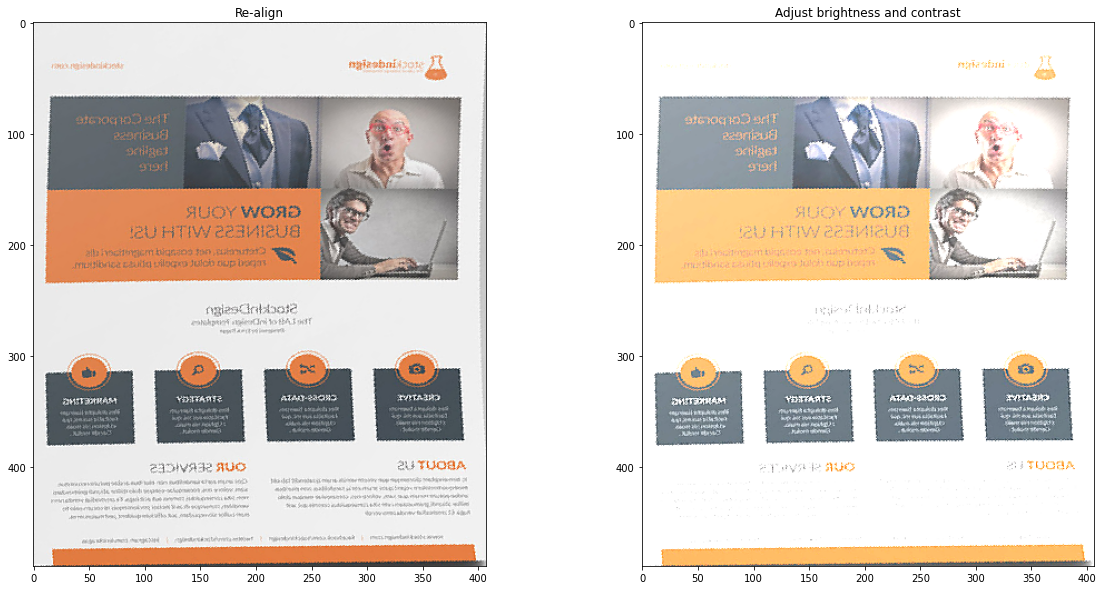

In [47]:
fig, axis = plt.subplots(1,2, figsize = (20,10));
axis[0].imshow(new_img);
axis[0].set_title('Re-align');
axis[1].imshow(new_image_jit);
axis[1].set_title('Adjust brightness and contrast');

### 4.So sánh

#### a.Làm xám ảnh

In [48]:
print("OpenCV vs Python (@jit): ", np.abs(gray_cv - gray_py).mean())

OpenCV vs Python (@jit):  0.046807056458338304


**Nhận xét**

- Kết quả nhóm tự cài đặt và OpenCV không có sự khác biệt quá lớn.

#### b.Giảm nhiễu

In [49]:
print("OpenCV vs Python (@jit): ", np.abs(gaussianBlur_cv - gaussianBlur_py).mean())

OpenCV vs Python (@jit):  0.8806040381951995


#### c.Canny

In [50]:
print("OpenCV vs Python (@jit): ", np.abs(canny_edge_cv - canny_edge_py).mean())

OpenCV vs Python (@jit):  0.9415041666666667


**Nhận xét**

- Kết quả nhóm tự cài đặt và OpenCV không có sự khác biệt khá lớn. Nguyên nhân khác biệt là do hàm giảm nhiễm có độ sai khác khá lớn.

#### d.Căn chỉnh lại (Homography)

In [51]:
# print("OpenCV vs Python (@jit): ", np.abs(warped - new_img).mean())

#### e.Điều chỉnh độ sáng, độ tương phản

In [52]:
# print("OpenCV vs Python (@jit): ", np.abs(new_image_cv - new_image_jit).mean())

**Nhận xét**

- Bức ảnh sau khi căn chỉnh khác nhau nên có sự khác biệt khá lớn. Bên cạnh đó, hàm tuần tự điều chỉnh độ sáng và độ tương phản còn sai sót.

## III.Tổng hợp và phân tích cho việc song song

### 1.Tổng hợp hàm tuần tự cho các bước

In [53]:
@jit(cache = True)
def enhance_img_1_py(img, gau_kernel, sobel_x_kernel, sobel_y_kernel):
    gray = convert_RGB_Gray_py(img)

    gaussianBlur = convolutionLayer_py(gray, gau_kernel)
    edge_sobel, angle = edgeGradient_py(gaussianBlur, sobel_x_kernel, sobel_y_kernel)
    non_max_sup = nonMaxSuppression(edge_sobel, angle)
    canny_edge = hysteresisThreshold(non_max_sup, 0.05, 0.15)
    canny_edge = canny_edge.astype(np.uint8)

    return canny_edge

def enhance_img_2(img):
    cnts, _ = cv2.findContours(img.copy(), cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
    cnts = sorted(cnts, key = lambda x:cv2.arcLength(x,True), reverse = True)
    cnts = cnts[0].squeeze()

    max_x, max_y = cnts[:,0].max(),cnts[:,1].max()
    min_x, min_y = cnts[:,0].min(), cnts[:,1].min()

    b_can, t_can = cnts[cnts[:,0] == max_x], cnts[cnts[:,0] == min_x]
    l_can, r_can = cnts[cnts[:,1] == min_y], cnts[cnts[:,1] == max_y]

    t = get_pos(t_can, min_y, max_y, 1)
    l = get_pos(l_can, min_x, max_x, 0)
    r = get_pos(r_can, min_x, max_x, 0)
    b = get_pos(b_can, min_y, max_y, 1)
    four_vertices_cnts = []

    get_4_vertices(t, l, r, b, four_vertices_cnts)
    tl, tr, br, bl = four_vertices_cnts = order_points_py(four_vertices_cnts, max_x, max_y, min_x, min_y)

    widthA = ((br[0] - bl[0]) ** 2 + (br[1] - bl[1]) ** 2) ** 0.5
    widthB = ((tr[0] - tl[0]) ** 2 + (tr[1] - tl[1]) ** 2) ** 0.5

    maxWidth = int(widthA) if int(widthA) > int(widthB) else int(widthB)

    heightA = ((tr[0] - br[0]) ** 2 + (tr[1] - br[1]) ** 2) ** 0.5
    heightB = ((tl[0] - bl[0]) ** 2 + (tl[1] - bl[1]) ** 2) ** 0.5

    maxHeight = int(heightA) if int(heightA) > int(heightB) else int(heightB)

    n_four_vertices_cnts = np.array([[0,0], 
                                    [0, maxWidth], 
                                    [maxHeight, maxWidth], 
                                    [maxHeight, 0]], dtype = 'float32')
    
    H = cv2.getPerspectiveTransform(four_vertices_cnts.astype('float32'), n_four_vertices_cnts)
    H = np.linalg.inv(H)

    return H, maxWidth, maxHeight

@jit(cache = True)
def enhance_img_3_py(img, H, width, height):
    new_img = np.zeros((width, height, 3)) if len(img.shape) == 3 else np.zeros((width, height))
    new_img = map_pos_homo(img, new_img, H)
    new_img = new_img.astype(int)
    
    return new_img

In [54]:
s = time.time()
step_1 = enhance_img_1_py(img, gau_kernel, sobel_x_kernel, sobel_y_kernel)
time_step1 = time.time() - s

s = time.time()
H, width, height = enhance_img_2(step_1)
time_step2 = time.time() - s

s = time.time()
step_3 = enhance_img_3_py(img, H, width, height)
time_step3 = time.time() - s

In [55]:
s = time.time()
step_1 = enhance_img_1_py(img, gau_kernel, sobel_x_kernel, sobel_y_kernel)
time_step1_cache = time.time() - s

H, width, height = enhance_img_2(step_1)

s = time.time()
step_3 = enhance_img_3_py(img, H, width, height)
time_step3_cache = time.time() - s

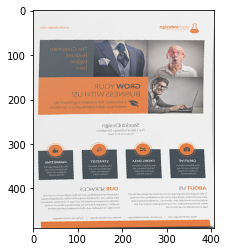

In [56]:
plt.imshow(step_3)
plt.show()

### 2.Thời gian thực thi

In [57]:
index_cv = ['time_gray_cv',
            'time_detectEdge_cv',
            'time_findCnts_cv',
            'time_4Vertices_cv',
            'time_homoMatrix_cv',
            'time_mapHomo_cv',
            'time_step4_cv']

index_step = ['time_step1','time_step2','time_step3','time_step1_cache','time_step3_cache']

index_py = ['time_gray_py',
            'time_blur_py',
            'time_grad_py',
            'time_nonmax_py',
            'time_thres_py',
            'time_findCnts_py',
            'time_4Vertices_py',
            'time_homoMatrix_py',
            'time_mapHomo_py',
            'time_step4_py']

index_cache = ['time_gray_cache',
               'time_blur_cache',
               'time_grad_cache',
               'time_nonmax_cache',
               'time_thres_cache',
               'time_mapHomo_cache',
               'time_step4_cache']

data_cv = [time_gray_cv,
           time_detectEdge_cv,
           time_findCnts_cv,
           time_4Vertices_cv,
           time_homoMatrix_cv,
           time_mapHomo_cv,
           time_step4_cv]

data_step = [time_step1,time_step2,time_step3,time_step1_cache,time_step3_cache]

data_py = [time_gray_py,
           time_blur_py,
           time_grad_py,
           time_nonmax_py,
           time_thres_py,
           time_findCnts_py,
           time_4Vertices_py,
           time_homoMatrix_py,
           time_mapHomo_py,
           time_step4_py]

data_cache = [time_gray_cache,
              time_blur_cache,
              time_grad_cache,
              time_nonmax_cache,
              time_thres_cache,
              time_mapHomo_cache,
              time_step4_cache]

In [58]:
df_time_cv = pd.DataFrame(data = data_cv, index = index_cv, columns = ['time (s)'])

In [59]:
df_time_py = pd.DataFrame(data = data_py, index = index_py, columns = ['time (s)'])
df_time_cache = pd.DataFrame(data = data_cache, index = index_cache, columns = ['time (s)'])

In [60]:
df_time_step = pd.DataFrame(data = data_step, index = index_step, columns = ['time (s)'])

In [61]:
df_time_cv.sort_values(by = 'time (s)', ascending=False)

time (s)
time_4Vertices_cv   1.253121
time_detectEdge_cv  0.015351
time_gray_cv        0.013652
time_findCnts_cv    0.006612
time_mapHomo_cv     0.006452
time_step4_cv       0.004214
time_homoMatrix_cv  0.002198

In [62]:
df_time_py.sort_values(by = 'time (s)', ascending=False)

time (s)
time_grad_py        6.632702
time_thres_py       0.693990
time_mapHomo_py     0.606239
time_nonmax_py      0.465968
time_gray_py        0.365816
time_blur_py        0.250865
time_step4_py       0.143507
time_findCnts_py    0.005108
time_homoMatrix_py  0.002747
time_4Vertices_py   0.002455

In [63]:
df_time_cache.sort_values(by = 'time (s)', ascending=False)

time (s)
time_grad_cache     0.058928
time_blur_cache     0.016777
time_nonmax_cache   0.010974
time_step4_cache    0.003922
time_mapHomo_cache  0.003785
time_thres_cache    0.003063
time_gray_cache     0.001841

In [64]:
df_time_step.sort_values(by = 'time (s)', ascending=False)

time (s)
time_step3        0.651205
time_step1        0.195091
time_step1_cache  0.086937
time_step3_cache  0.014635
time_step2        0.003900

#### **Nhận xét**
* Các bước: `xác định 4 đỉnh` (time_4Vertices), `xác định viền` (time_findCnts) và `tìm ma trận Homography` (time_homoMatrix) không phù hợp để thực hiện song song hóa. 
    * Với bước xác định 4 đỉnh, chủ yếu là tìm ra những điểm có tọa độ x hoặc y là cực đại hoặc cực tiểu sau đó xác định thứ tự của các đỉnh, lượng công việc ở đây **nhỏ** nên khi thực hiện song song hóa sẽ không cải thiện được tốc độ, có thể dẫn đến kết quả tệ hơn.
    * Bước xác định viền, do sử dụng hàm của OpenCV nên không có hàm tuần tự để có thể thiết kế, phân tích.
    * Bước tìm ma trận Homography sẽ dùng hàm của OpenCV. Nhóm quyết định sử dụng hàm OpenCV ở đây vì bước này chỉ xác định ma trận biến đối dựa trên 4 cặp đỉnh, khối lượng công việc khá nhỏ, và OpenCV có sẵn những tối ưu cho các hàm built-in của mình nên tốc độ sẽ nhanh hơn khi tự chạy bằng các hàm của Numpy.
* Thời gian thực thi của bước `tính gradient và hướng gradient` tốn nhiều thời gian nhất, hơn 8s khi không được cache lại và 0.06s khi đã được cache.
* Các bước trong step 1, 3, 4 có thể tăng tốc bằng cách sử dụng song song vì thao tác trên các pixel là như nhau và số lượng các pixel lớn.
* Thời gian thực thi của bước xác định tọa độ mới nằm trong top 4 những hàm có thể song song hóa và thời gian thực thi chậm nhất (0.9s và 0.01s khi đã cache).

$⇒$ Thực hiện song song hóa cho hàm:

* `Hàm làm xám ảnh`
* `Hàm làm mờ ảnh`
* `Hàm tính gradient và hướng gradient`
* `Hàm tính non-max suppression`
* `Hàm lọc ngưỡng`
* `Hàm tính tọa độ mới`
* `Hàm điều chỉnh độ sáng, độ tương phản`




## IV.Song song hóa

### 1.Thiết kế

- Vì các pixel trong mảng output sẽ được tính độc lập (không phụ thuộc vào các pixel khác) $\rightarrow$ Một thread sẽ xử lý một pixel tương ứng.

- Toàn bộ ma trận input sẽ được chia thành một grid với kích thước (m,n) và mỗi grid sẽ có blocksize là (32,32) vì số lượng thread tối đa của mỗi block là 1024.

In [65]:
block_size = (32,32)

### 2.Các hàm xử lý ảnh

#### a.Làm xám ảnh

In [66]:
@cuda.jit
def convert_RGB_Gray_kernel(img_in, img_out):
    c,r = cuda.grid(2)
    if r < img_in.shape[0] and c < img_in.shape[1]:
        img_out[r,c] =  img_in[r,c,0] * 0.2989  + img_in[r,c,1] * 0.5870 + img_in[r,c,2] * 0.1141

#### b.Tính tích chập

In [67]:
@cuda.jit
def convolutionLayer_kernel(img_in, img_out, kernel):
    c,r = cuda.grid(2)
    if r < img_in.shape[0] and c < img_in.shape[1]:
        result = 0
        for i in range(kernel.shape[0]):
            for j in range(kernel.shape[1]):
                in_r = r - kernel.shape[0]//2 + i;
                in_c = c - kernel.shape[1]//2 + j;
                in_r = min(max(0, in_r), img_in.shape[0] - 1);
                in_c = min(max(0, in_c), img_in.shape[1] - 1);
                result += kernel[i,j] * img_in[in_r,in_c];
        img_out[r,c] = result

#### c.Làm mờ ảnh

In [68]:
@cuda.jit
def convolutionLayer_kernel(img_in, img_out, kernel):
    c,r = cuda.grid(2)
    if r < img_in.shape[0] and c < img_in.shape[1]:
        result = 0
        for i in range(kernel.shape[0]):
            for j in range(kernel.shape[1]):
                in_r = r - kernel.shape[0]//2 + i;
                in_c = c - kernel.shape[1]//2 + j;
                in_r = min(max(0, in_r), img_in.shape[0] - 1);
                in_c = min(max(0, in_c), img_in.shape[1] - 1);
                result += kernel[i,j] * img_in[in_r,in_c];
        img_out[r,c] = result

#### d.Tính gradient và hướng gradient

In [69]:
@cuda.jit
def gradient_kernel(img_in, img_out, angle, kernel_x, kernel_y):
    c,r = cuda.grid(2)
    if r < img_in.shape[0] and c < img_in.shape[1]:
        result_x = 0
        result_y = 0
        for i in range(kernel_x.shape[0]):
            for j in range(kernel_x.shape[1]):
                in_r = r - kernel_x.shape[0]//2 + i;
                in_c = c - kernel_x.shape[1]//2 + j;
                in_r = min(max(0, in_r), img_in.shape[0] - 1);
                in_c = min(max(0, in_c), img_in.shape[1] - 1);
                result_x += kernel_x[i,j] * img_in[in_r,in_c];
                result_y += kernel_y[i,j] * img_in[in_r,in_c];
        img_out[r,c] = ((result_x ** 2) + (result_y ** 2)) ** 0.5
        angle[r,c] = math.atan2(result_y, result_x) * (180 / np.pi) 
        angle[r,c] = angle[r,c] if angle[r,c] >= 0 else angle[r,c]+180 

#### e.Tính non-max suppression

In [70]:
@cuda.jit
def nonMaxSuppression_kernel(img_in, img_out, angle):
    c,r = cuda.grid(2)
    if 0 < r <= img_in.shape[0] - 1 and 0 < c < img_in.shape[1]-1:
        q, t = 255, 255
        if 0 <= angle[r,c] < 22.5 or 180 >= angle[r,c] >= 157.5:
            q, t = img_in[r, c+1], img_in[r, c-1]
        elif 67.5 > angle[r,c] >= 22.5:
            q, t = img_in[r+1, c-1], img_in[r-1, c+1]
        elif 112.5 > angle[r,c] >= 67.5:
            q, t = img_in[r+1, c], img_in[r-1, c]
        elif 157.5 > angle[r,c] >= 112.5:
            q, t = img_in[r-1, c-1], img_in[r+1, c+1]

        if img_in[r,c] >=q and img_in[r,c] >=t:
            img_out[r,c] = img_in[r,c]
        else:
            img_out[r,c] = 0

#### f.Hàm lọc ngưỡng

In [71]:
@cuda.jit
def hysteresisThreshold_kernel(img_in,img_out, min_val, max_val):
    c, r = cuda.grid(2)
    if r < img_in.shape[0] and c < img_in.shape[1]:
        if img_in[r,c] > max_val:
            img_out[r,c] = 255
        elif img_in[r,c] > min_val:
            is_edge = False
            for i in range(max(0, r-1), min(img_in.shape[0], r+2)):
                for j in range(max(0, c-1), min(img_in.shape[1], c+2)):
                    if img_in[i,j] > max_val:
                        is_edge = True
                        img_out[r,c] = 255
                        break
                if is_edge:
                    break

#### g.Map tọa độ mới cho ảnh

In [72]:
@cuda.jit
def map_homo_kernel(img_in, img_out, H):
    c,r = cuda.grid(2)
    if r < maxWidth and c < maxHeight:
        x = int((H[0,0] * c + H[0,1] * r + H[0,2]) / (H[2,0] * c + H[2,1] * r + H[2,2]))
        y = int((H[1,0] * c + H[1,1] * r + H[1,2]) / (H[2,0] * c + H[2,1] * r + H[2,2]))
        if 0 <= y < img_in.shape[0] and 0 <= x < img_in.shape[1]:
            img_out[r,c] = img_in[y, x]
            

### 3.Thực thi

#### a.Làm xám ảnh

**Compiler**

In [73]:
gray_kernel = np.zeros((img.shape[0], img.shape[1]))

grid_size = (math.ceil(gray_kernel.shape[1] / block_size[0]), #chieu x
             math.ceil(gray_kernel.shape[0] / block_size[1])) #chieu y

s = time.time()
convert_RGB_Gray_kernel[grid_size, block_size](img, gray_kernel)
time_gray_comp = time.time() - s

**Run**

In [74]:
gray_kernel = np.zeros((img.shape[0], img.shape[1]))

grid_size = (math.ceil(gray_kernel.shape[1] / block_size[0]), #chieu x
             math.ceil(gray_kernel.shape[0] / block_size[1])) #chieu y

s = time.time()
convert_RGB_Gray_kernel[grid_size, block_size](img, gray_kernel)
time_gray_pp = time.time() - s

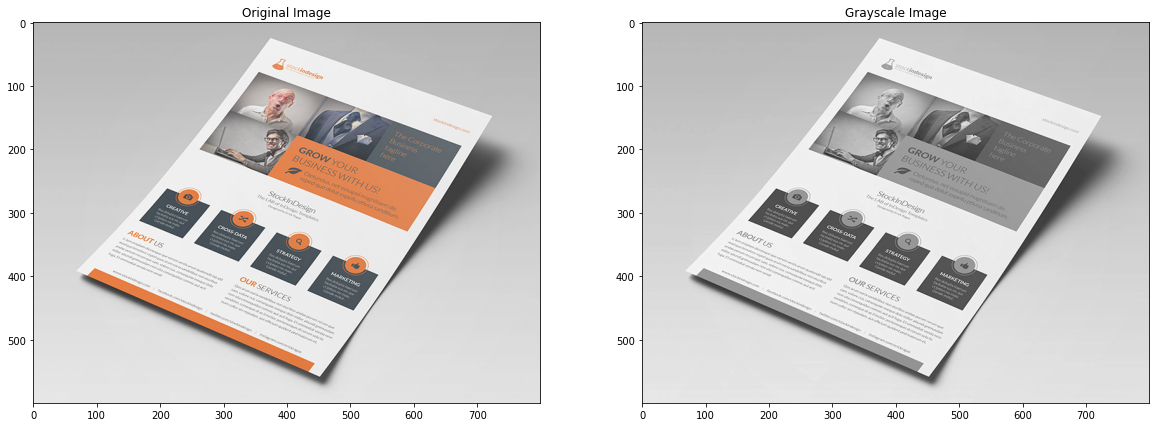

In [75]:
fig, axis = plt.subplots(1,2, figsize = (20,10));
axis[0].imshow(img);
axis[0].set_title('Original Image');
axis[1].imshow(gray_kernel, cmap = 'gray');
axis[1].set_title('Grayscale Image');

In [76]:
print("OpenCV vs Parallel : ", np.abs(gray_cv - gray_kernel).mean())
print("@jit vs Parallel : ", np.abs(gray_py - gray_kernel).mean())

OpenCV vs Parallel :  0.04680705645834055
@jit vs Parallel :  7.870482043870198e-15


#### b.Xác định biên cạnh

##### Làm mờ ảnh

**Compiler**

In [77]:
conv = np.zeros(gray_kernel.shape)

grid_size = (math.ceil(conv.shape[1] / block_size[0]), #chieu x
             math.ceil(conv.shape[0] / block_size[1])) #chieu y

s = time.time()
convolutionLayer_kernel[grid_size, block_size](gray_kernel, conv, gau_kernel)
time_blur_comp = time.time() - s

**Run**

In [78]:
conv = np.zeros(gray_kernel.shape)

grid_size = (math.ceil(conv.shape[1] / block_size[0]), #chieu x
             math.ceil(conv.shape[0] / block_size[1])) #chieu y

s = time.time()
convolutionLayer_kernel[grid_size, block_size](gray_kernel, conv, gau_kernel)
time_blur_pp = time.time() - s

##### Tính gradient và hướng gradient

**Compiler**

In [79]:
edge_gradient = np.zeros(gray_kernel.shape)
angle_kernel = np.zeros(gray_kernel.shape)

block_size = (32,32)
grid_size = (math.ceil(edge_gradient.shape[1] / block_size[0]), #chieu x
             math.ceil(edge_gradient.shape[0] / block_size[1])) #chieu y

s = time.time()
gradient_kernel[grid_size, block_size](conv, edge_gradient, angle_kernel, sobel_x_kernel, sobel_y_kernel)
time_grad_comp = time.time() - s

**Run**

In [80]:
edge_gradient = np.zeros(gray_kernel.shape)
angle_kernel = np.zeros(gray_kernel.shape)

grid_size = (math.ceil(edge_gradient.shape[1] / block_size[0]), #chieu x
             math.ceil(edge_gradient.shape[0] / block_size[1])) #chieu y

s = time.time()
gradient_kernel[grid_size, block_size](conv, edge_gradient,angle_kernel, sobel_x_kernel, sobel_y_kernel)
time_grad_pp = time.time() - s

In [81]:
print("Python (@jit) vs Kernel: ", np.abs(edge_sobel_py - edge_gradient).mean())

Python (@jit) vs Kernel:  4.20327102098757e-14


##### Tính non-max suppression

**Compiler**

In [82]:
non_max_kernel = np.zeros(edge_gradient.shape)

grid_size = (math.ceil(edge_gradient.shape[1] / block_size[0]), #chieu x
             math.ceil(edge_gradient.shape[0] / block_size[1])) #chieu y

s = time.time()
nonMaxSuppression_kernel[grid_size, block_size](edge_gradient, non_max_kernel, angle_kernel)
time_nonmax_comp = time.time() - s

**Run**

In [83]:
non_max_kernel = np.zeros(edge_gradient.shape)

grid_size = (math.ceil(edge_gradient.shape[1] / block_size[0]), #chieu x
             math.ceil(edge_gradient.shape[0] / block_size[1])) #chieu y

s = time.time()
nonMaxSuppression_kernel[grid_size, block_size](edge_gradient, non_max_kernel, angle_kernel)
time_nonmax_pp = time.time() - s

In [84]:
print("Python (@jit) vs Kernel: ", np.abs(non_max_sup_py - non_max_kernel).mean())

Python (@jit) vs Kernel:  0.11714438286043317


##### Hàm lọc ngưỡng

**Compiler**

In [85]:
min_thres = 0.05
max_thres = 0.15

max_val = img.max() * max_thres
min_val = max_val * min_thres

canny_edge_kernel = np.zeros(non_max_kernel.shape, np.int32)

grid_size = (math.ceil(non_max_kernel.shape[1] / block_size[0]), #chieu x
             math.ceil(non_max_kernel.shape[0] / block_size[1])) #chieu y

s = time.time()
hysteresisThreshold_kernel[grid_size, block_size](non_max_kernel, canny_edge_kernel, min_val, max_val)
time_thres_comp = time.time() - s

**Run**

In [86]:
min_thres = 0.05
max_thres = 0.15

max_val = img.max() * max_thres
min_val = max_val * min_thres

canny_edge_kernel = np.zeros(non_max_kernel.shape, np.int32)

grid_size = (math.ceil(non_max_kernel.shape[1] / block_size[0]), #chieu x
             math.ceil(non_max_kernel.shape[0] / block_size[1])) #chieu y

s = time.time()
hysteresisThreshold_kernel[grid_size, block_size](non_max_kernel, canny_edge_kernel, min_val, max_val)
time_thres_pp = time.time() - s

canny_edge_kernel  = canny_edge_kernel.astype(np.uint8)

In [87]:
print("Python (@jit) vs Kernel: ", np.abs(canny_edge_py - canny_edge_kernel).mean())

Python (@jit) vs Kernel:  0.007910416666666666


#### c.Tìm viền ảnh (Sử dụng Numpy và hàm của OpenCV)

In [88]:
cnts, _ = cv2.findContours(canny_edge_kernel.copy(), cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
cnts = sorted(cnts, key = lambda x:cv2.arcLength(x,True), reverse = True)

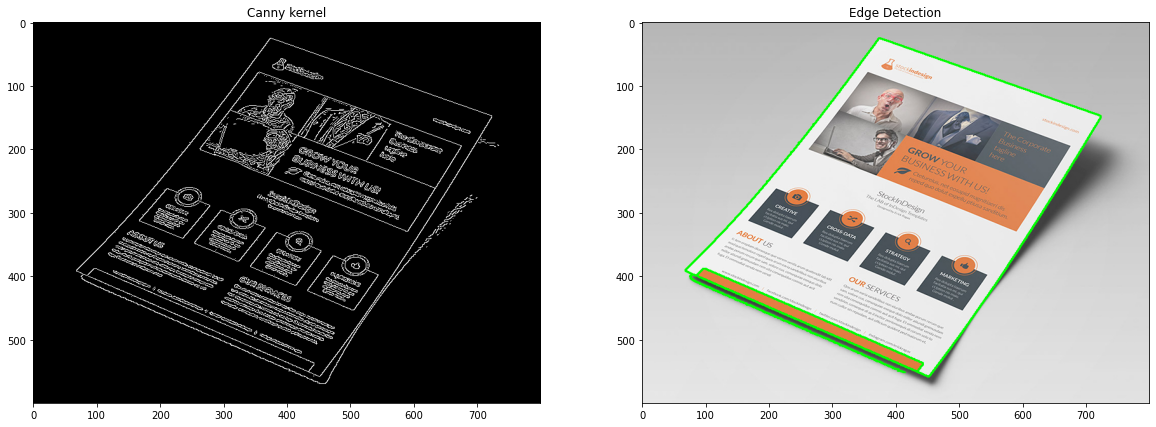

In [89]:
output_edge_kernel = img.copy()
cv2.drawContours(output_edge_kernel, cnts, 0, (0, 255, 0), 2)

fig, axis = plt.subplots(1,2, figsize = (20,10));
axis[0].imshow(canny_edge_kernel, cmap='gray');
axis[0].set_title('Canny kernel');
axis[1].imshow(output_edge_kernel);
axis[1].set_title('Edge Detection');

In [90]:
print("Python (@jit) vs Kernel: ", np.abs(output_edge_jit - output_edge_kernel).mean())

Python (@jit) vs Kernel:  0.09477083333333333


#### d.Tìm ma trận Homography (Sử dụng Numpy và hàm của OpenCV)

In [91]:
choosen_cnt = cnts[0].squeeze()

max_x, max_y = choosen_cnt[:,0].max(),choosen_cnt[:,1].max()
min_x, min_y = choosen_cnt[:,0].min(), choosen_cnt[:,1].min()

b_can, t_can = choosen_cnt[choosen_cnt[:,0] == max_x], choosen_cnt[choosen_cnt[:,0] == min_x]
l_can, r_can = choosen_cnt[choosen_cnt[:,1] == min_y], choosen_cnt[choosen_cnt[:,1] == max_y]

t, b = get_pos(t_can, min_y, max_y, 1), get_pos(b_can, min_y, max_y, 1)
l, r = get_pos(l_can, min_x, max_x, 0), get_pos(r_can, min_x, max_x, 0)

four_vertices_cnts = []

get_4_vertices(t, l, r, b, four_vertices_cnts)
four_vertices_cnts = order_points_py(four_vertices_cnts, max_x, max_y, min_x, min_y)

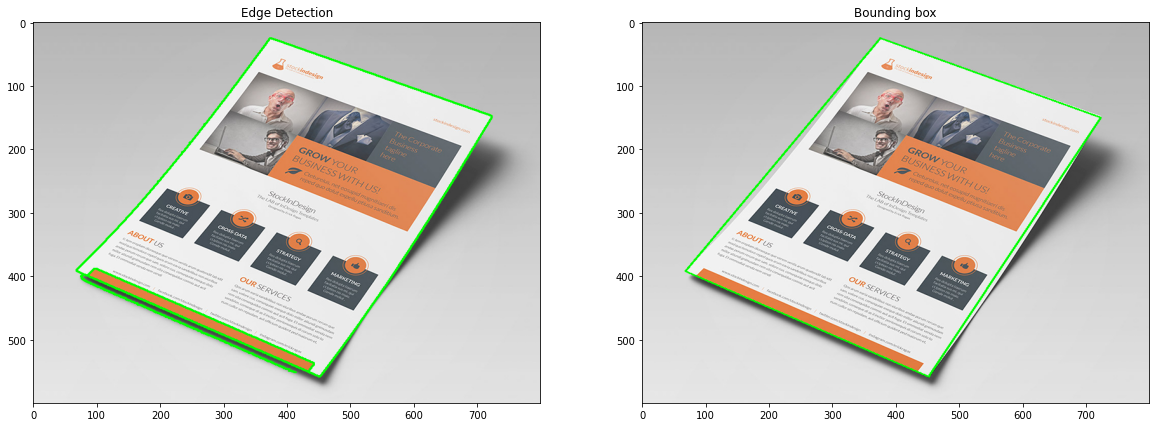

In [92]:
output_4_points_kernel = img.copy()
cv2.drawContours(output_4_points_kernel, [four_vertices_cnts], 0, (0, 255, 0), 2)

fig, axis = plt.subplots(1,2, figsize = (20,10));
axis[0].imshow(output_edge_kernel);
axis[0].set_title('Edge Detection');
axis[1].imshow(output_4_points_kernel);
axis[1].set_title('Bounding box');

In [93]:
tl, tr, br, bl = four_vertices_cnts

widthA = ((br[0] - bl[0]) ** 2 + (br[1] - bl[1]) ** 2) ** 0.5
widthB = ((tr[0] - tl[0]) ** 2 + (tr[1] - tl[1]) ** 2) ** 0.5

maxWidth = int(widthA) if int(widthA) > int(widthB) else int(widthB)

heightA = ((tr[0] - br[0]) ** 2 + (tr[1] - br[1]) ** 2) ** 0.5
heightB = ((tl[0] - bl[0]) ** 2 + (tl[1] - bl[1]) ** 2) ** 0.5

maxHeight = int(heightA) if int(heightA) > int(heightB) else int(heightB)

n_four_vertices_cnts = [n_tl, n_tr, n_br, n_bl] = np.array([[0,0], 
                                                   [0, maxWidth-1], 
                                                   [maxHeight-1, maxWidth - 1], 
                                                   [maxHeight - 1, 0]], dtype = 'float32')

H = np.linalg.inv(cv2.getPerspectiveTransform(four_vertices_cnts.astype('float32'), n_four_vertices_cnts))

#### e.Map tọa độ mới cho ảnh

**Compiler**

In [94]:
# new_img = np.zeros((maxWidth, maxHeight, img.shape[-1]), img.dtype)
# grid_size = (math.ceil(maxHeight / block_size[0]), #chieu x
#              math.ceil(maxWidth / block_size[1])) #chieu y

# s = time.time()
# map_homo_kernel[grid_size, block_size](img, new_img, H)
# time_mapHomo_comp = time.time() - s

# new_img = new_img.astype(int)

**Run**

In [95]:
# new_img = np.zeros((maxWidth, maxHeight, img.shape[-1]), img.dtype)
# block_size = (32,32)
# grid_size = (math.ceil(maxHeight / block_size[0]), #chieu x
#              math.ceil(maxWidth / block_size[1])) #chieu y

# s = time.time()
# map_homo_kernel[grid_size, block_size](img, new_img, H)
# time_mapHomo_pp = time.time() - s

# new_img = new_img.astype(int)

#### f.Hàm điều chỉnh độ sáng, độ tương phản

### 4.Đánh giá

In [96]:
index_pp = ['time_gray_comp',
            'time_gray_pp',
            'time_blur_comp',
            'time_blur_pp',
            'time_grad_comp',
            'time_grad_pp',
            'time_nonmax_comp',
            'time_nonmax_pp',
            'time_thres_comp',
            'time_thres_pp']

data_pp = [time_gray_comp,
           time_gray_pp,
           time_blur_comp,
           time_blur_pp,
           time_grad_comp,
           time_grad_pp,
           time_nonmax_comp,
           time_nonmax_pp,
           time_thres_comp,
           time_thres_pp]

In [97]:
df_time_pp1 = pd.DataFrame(data = data_pp, index = index_pp, columns = ['time (s)'])

In [98]:
df_time_pp1.sort_values(by = 'time (s)', ascending=False)

time (s)
time_gray_comp    0.756702
time_grad_comp    0.483446
time_nonmax_comp  0.386278
time_thres_comp   0.214443
time_blur_comp    0.212212
time_grad_pp      0.013536
time_nonmax_pp    0.008335
time_blur_pp      0.006656
time_thres_pp     0.005116
time_gray_pp      0.004728

In [99]:
df_time_py.sort_values(by = 'time (s)', ascending=False)

time (s)
time_grad_py        6.632702
time_thres_py       0.693990
time_mapHomo_py     0.606239
time_nonmax_py      0.465968
time_gray_py        0.365816
time_blur_py        0.250865
time_step4_py       0.143507
time_findCnts_py    0.005108
time_homoMatrix_py  0.002747
time_4Vertices_py   0.002455

In [100]:
df_time_cache.sort_values(by = 'time (s)', ascending=False)

time (s)
time_grad_cache     0.058928
time_blur_cache     0.016777
time_nonmax_cache   0.010974
time_step4_cache    0.003922
time_mapHomo_cache  0.003785
time_thres_cache    0.003063
time_gray_cache     0.001841